In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier


In [27]:
# !pip install -U imbalanced-learn

In [28]:
# !pip install xgboost

In [2]:
df=pd.read_csv('/Users/shwethailango/Documents/Work/Solarillion/Flight_delay_pred/Data/data_processed/flight_delay_pred.csv')

In [3]:
df1=df.drop(columns=['FlightDate', 'airport','Unnamed: 0','DayofMonth.1'],axis=1)

In [4]:
df1.shape

(1851436, 27)

### Function for training model for classifers

In [5]:
def train_model(x,y,model):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.33)
    model.fit(x_train,y_train)
    ypred=model.predict(x_test)
    return ypred,y_test


# Feature Selection


### Since there are 30 features, we must select best features as independent variables. There are many ways and here we use,
1.PCA <br> 2. Univariate Selection <br> 3. Feature Importance using ExtraTreesClassifier



## 1.PCA  

In [33]:
#1. Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(df1)
scaled_data = scaler.fit_transform(df1)#scaled_data:ndarray
std_df1=pd.DataFrame(scaled_data)  #std_df1:df
 

In [34]:
#decomposition for _ features
from sklearn.decomposition import PCA
pca = PCA(n_components=15)

pca.fit(std_df1)
x_pca=pca.fit_transform(std_df1) #x_pca:ndarray
x_df1=pd.DataFrame(x_pca)        #x_df1:df


In [9]:
std_df1.shape,x_df1.shape

((1851436, 27), (1851436, 15))

### Training model

In [70]:
x=np.array(x_df1)
y=np.array(df1[['ArrDel15']])


In [71]:
ypred1,ytest=train_model(x,y,LogisticRegression())

/Users/shwethailango/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Validation 

In [72]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ytest, ypred1))
print("Precision:",metrics.precision_score(ytest, ypred1))
print("Recall:",metrics.recall_score(ytest, ypred1))
print("confusion matrix \n",metrics.confusion_matrix(ytest,ypred1))
print("f1 score:",metrics.f1_score(ytest,ypred1))
print("cohen's kappa:",metrics.cohen_kappa_score(ytest,ypred1))


Accuracy: 0.9609246874662424
Precision: 0.8875259890752734
Recall: 0.9313335262240087
confusion matrix 
 [[468002  15093]
 [  8781 119098]]
f1 score: 0.9089022017018354
cohen's kappa: 0.8840486552829601


Text(0, 0.5, 'True positive rate')

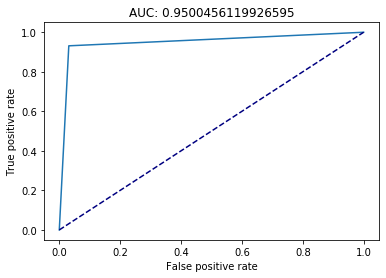

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(ytest, ypred1, pos_label=1)
auc = roc_auc_score(ytest, ypred1)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

# 2.Univariate and XGBoost
f_classif refers ANOVA test as statistics test

In [73]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [74]:
x=df1.drop(columns=['ArrDel15'],axis=1)
y=df1[['ArrDel15']]


In [75]:
model=SelectKBest(score_func=f_classif,k=17)
kb_fit=model.fit(x,y)

/Users/shwethailango/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [76]:
dfscores = pd.DataFrame(kb_fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores=featureScores.nlargest(17,'Score')


In [77]:
kbest=featureScores.iloc[:,0].values

In [78]:
len(kbest)
kbest

array(['DepDel15', 'ArrDelayMinutes', 'DepDelayMinutes', 'DepTime',
       'CRSDepTime', 'time', 'CRSArrTime', 'weatherCode', 'precipMM',
       'windspeedKmph', 'WindGustKmph', 'pressure', 'ArrTime',
       'DestAirportID', 'DewPointF', 'cloudcover', 'tempF'], dtype=object)

In [79]:
X=df1[kbest]

In [80]:
X=X.drop(columns=['ArrDelayMinutes','CRSArrTime','ArrTime'],axis=1)
y=df1[['ArrDel15']]

### training model

In [81]:
ypred2,ytest=train_model(X,y,XGBClassifier())

/Users/shwethailango/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### validation

In [82]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred2))
print("Precision:",metrics.precision_score(ytest, ypred2))
print("Recall:",metrics.recall_score(ytest, ypred2))
print("confusion matrix \n",metrics.confusion_matrix(ytest,ypred2))
print("f1 score:",metrics.f1_score(ytest,ypred2))
print("cohen's kappa:",metrics.cohen_kappa_score(ytest,ypred2))

Accuracy: 0.9178557516359125
Precision: 0.894727215453557
Recall: 0.6885493317902079
confusion matrix 
 [[472735  10360]
 [ 39828  88051]]
f1 score: 0.7782137964558751
cohen's kappa: 0.7288519681923411


# 3.Feature Importance using ExtraTreesClassifier

In [6]:
x=df1.drop(columns=['ArrDel15'],axis=1)
y=df1[['ArrDel15']]


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x,y)

/Users/shwethailango/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ExtraTreesClassifier()

In [8]:
print(model.feature_importances_)

[0.00953686 0.00625958 0.00326288 0.00519132 0.00270354 0.00581924
 0.0128667  0.01794153 0.06465396 0.42267353 0.00853697 0.02285673
 0.0247925  0.322871   0.00680858 0.00654713 0.0055743  0.00628969
 0.00630521 0.0037651  0.00620976 0.00629066 0.00637418 0.00303287
 0.00638994 0.00644622]


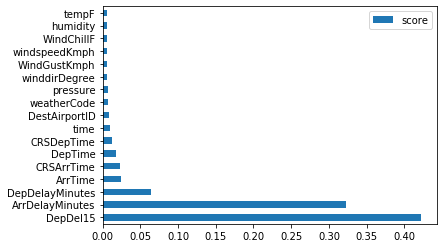

In [9]:
feat_importances = pd.DataFrame(model.feature_importances_, index=x.columns,columns=['score'])
feat_importances.nlargest(17,'score').plot(kind='barh')
plt.show()

In [10]:
f_imp=feat_importances.sort_values(by='score',ascending=False).iloc[0:17,:].index

In [11]:
len(f_imp)
f_imp

Index(['DepDel15', 'ArrDelayMinutes', 'DepDelayMinutes', 'ArrTime',
       'CRSArrTime', 'DepTime', 'CRSDepTime', 'time', 'DestAirportID',
       'weatherCode', 'pressure', 'winddirDegree', 'WindGustKmph',
       'windspeedKmph', 'WindChillF', 'humidity', 'tempF'],
      dtype='object')

In [12]:
f_imp=['DepDelayMinutes', 'DepTime', 'CRSDepTime', 'time', 'DestAirportID',
       'weatherCode', 'pressure', 'winddirDegree', 'WindGustKmph',
       'windspeedKmph', 'WindChillF', 'DewPointF', 'humidity','tempF']

In [13]:
X=df1[f_imp]
y=df1[['ArrDel15']]

### Training model

In [96]:
ypred3,y_test=train_model(X,y,DecisionTreeClassifier())

### Validation

In [97]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred3))
print("Precision:",metrics.precision_score(y_test, ypred3))
print("Recall:",metrics.recall_score(y_test, ypred3))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test, ypred3)
cnf_matrix

Accuracy: 0.8640400409837408
Precision: 0.6676318093057707
Recall: 0.6978080842045996
Confusion matrix


array([[438671,  44424],
       [ 38644,  89235]])

Text(0, 0.5, 'True positive rate')

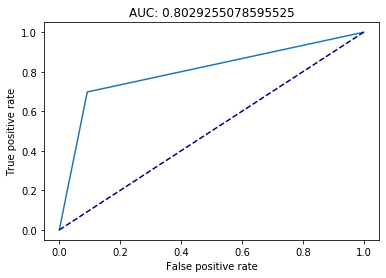

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, ypred3, pos_label=1)

auc = roc_auc_score(y_test, ypred3)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

# SAMPLING IMBALANCED DATA

In [99]:
df1['ArrDel15'].value_counts()

0.0    1463378
1.0     388058
Name: ArrDel15, dtype: int64

Text(0, 0.5, 'Frequency')

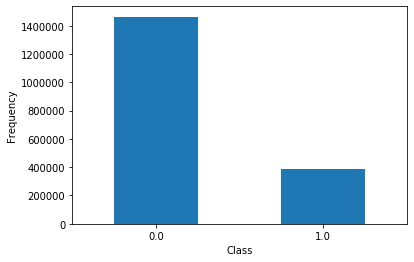

In [100]:
count_classes = pd.value_counts(df1['ArrDel15'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xlabel("Class")
plt.ylabel("Frequency")


## Techniques to sample unbalanced data, 
1.UnderSampling(NearMiss)<br>
2.Oversampling(ADASYN)<br>
3.Combine sampling(SMOTETomek)<br>
4.AdaBoost<br>
5.Bagging<br>

## 1.Under sampling

In [26]:
nm = NearMiss()
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=42)
x_us, y_us = nm.fit_resample(x, y)


Text(0, 0.5, 'Frequency')

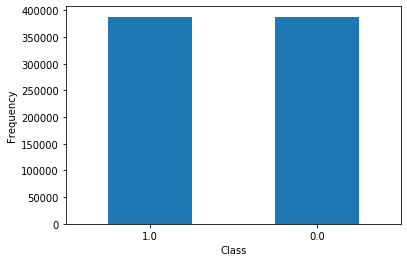

In [27]:
count_classes = pd.value_counts(y_us, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.xlabel("Class")

plt.ylabel("Frequency")


## 2.Over sampling

In [28]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)
x_os,y_os=smk.fit_sample(x,y)

Text(0, 0.5, 'Frequency')

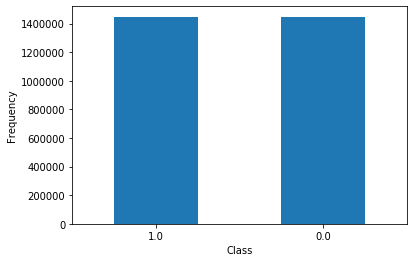

In [114]:
count_classes = pd.value_counts(y_os, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.xlabel("Class")

plt.ylabel("Frequency")


## ADASYN 

In [29]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42)
x_as, y_as = ada.fit_resample(x, y)

Text(0, 0.5, 'Frequency')

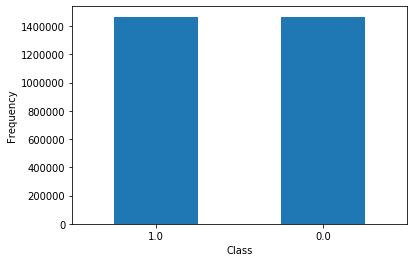

In [123]:
count_classes = pd.value_counts(y_as, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.xlabel("Class")

plt.ylabel("Frequency")


## Adaboost

In [16]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=42,test_size=0.2)

In [19]:
from sklearn.ensemble import AdaBoostClassifier

boost_clf = AdaBoostClassifier()

boost_clf.fit(xtrain, ytrain)

ypred = boost_clf.predict(xtest)



In [18]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred))
print("Precision:",metrics.precision_score(ytest, ypred))
print("Recall:",metrics.recall_score(ytest, ypred))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
cnf_matrix

Accuracy: 0.9160653329300437
Precision: 0.8904290982232652
Recall: 0.6839929956480313
Confusion matrix


array([[286085,   6537],
       [ 24543,  53123]])

In [20]:
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    292622
         1.0       0.89      0.68      0.77     77666

    accuracy                           0.92    370288
   macro avg       0.91      0.83      0.86    370288
weighted avg       0.91      0.92      0.91    370288



## Bagging

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)

In [25]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier()

bagging_clf.fit(x_train, y_train)
y_pred = bagging_clf.predict(x_test)



In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Accuracy: 0.9110584193924729
Precision: 0.8719360095786077
Recall: 0.6751087992171607
Confusion matrix


array([[284921,   7701],
       [ 25233,  52433]])

In [24]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95    292622
         1.0       0.87      0.68      0.76     77666

    accuracy                           0.91    370288
   macro avg       0.90      0.82      0.85    370288
weighted avg       0.91      0.91      0.91    370288



## XGBoost (sampled vs unsampled)

#### 1.Unsampled

In [14]:
x=np.array(df1[f_imp])
y=np.array(df1['ArrDel15'])

In [19]:
ypred,ytest=train_model(x,y,XGBClassifier())

In [22]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred))
print("Precision:",metrics.precision_score(ytest, ypred))
print("Recall:",metrics.recall_score(ytest, ypred))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest, ypred))
print(metrics.classification_report(ytest, ypred))

Accuracy: 0.9178803025988013
Precision: 0.895692025664528
Recall: 0.6877438828892938
Confusion matrix
[[472853  10242]
 [ 39931  87948]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    483095
         1.0       0.90      0.69      0.78    127879

    accuracy                           0.92    610974
   macro avg       0.91      0.83      0.86    610974
weighted avg       0.92      0.92      0.91    610974



#### 2. Undersampled

In [33]:
y_pred,y_test=train_model(x_us,y_us,XGBClassifier())

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.8874429464428645
Precision: 0.9267659845009193
Recall: 0.841590338134099
Confusion matrix
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89    127945
         1.0       0.93      0.84      0.88    128174

    accuracy                           0.89    256119
   macro avg       0.89      0.89      0.89    256119
weighted avg       0.89      0.89      0.89    256119



#### 3.Oversampled

In [35]:
y_pred3,y_test3=train_model(x_as,y_as,XGBClassifier())

In [36]:
print("Accuracy:",metrics.accuracy_score(y_test3, y_pred3))
print("Precision:",metrics.precision_score(y_test3, y_pred3))
print("Recall:",metrics.recall_score(y_test3, y_pred3))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test3, y_pred3)
print(metrics.classification_report(y_test3, y_pred3))

Accuracy: 0.9451790328801715
Precision: 0.9760024529159259
Recall: 0.9130490409517226
Confusion matrix
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    482462
         1.0       0.98      0.91      0.94    484595

    accuracy                           0.95    967057
   macro avg       0.95      0.95      0.95    967057
weighted avg       0.95      0.95      0.95    967057



#### 4.Combined

In [37]:
y_pred,y_test=train_model(x_os,y_os,XGBClassifier())

In [38]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9482339739798626
Precision: 0.9757039070533963
Recall: 0.9193931517141644
Confusion matrix
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    477524
         1.0       0.98      0.92      0.95    477813

    accuracy                           0.95    955337
   macro avg       0.95      0.95      0.95    955337
weighted avg       0.95      0.95      0.95    955337



## Decision Tree (sampled vs unsampled)

#### 1. Unsampled

In [39]:
x=np.array(df1[f_imp])
y=np.array(df1['ArrDel15'])

In [40]:
ypred,ytest=train_model(x,y,DecisionTreeClassifier())

In [47]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred))
print("Precision:",metrics.precision_score(ytest, ypred))
print("Recall:",metrics.recall_score(ytest, ypred))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest, ypred))
print(metrics.classification_report(ytest, ypred))

Accuracy: 0.8638665475126601
Precision: 0.6672002513333383
Recall: 0.6975031084071661
Confusion matrix
[[438604  44491]
 [ 38683  89196]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91    483095
         1.0       0.67      0.70      0.68    127879

    accuracy                           0.86    610974
   macro avg       0.79      0.80      0.80    610974
weighted avg       0.87      0.86      0.86    610974



### 2. Undersampled

In [41]:
ypred2,ytest2=train_model(x_us,y_us,DecisionTreeClassifier())

In [42]:
print("Accuracy:",metrics.accuracy_score(ytest2, ypred2))
print("Precision:",metrics.precision_score(ytest2, ypred2))
print("Recall:",metrics.recall_score(ytest2, ypred2))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest2, ypred2))
print(metrics.classification_report(ytest2, ypred2))

Accuracy: 0.8278144143933094
Precision: 0.8258278043033422
Recall: 0.8312528281866838
Confusion matrix
[[105474  22471]
 [ 21629 106545]]
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83    127945
         1.0       0.83      0.83      0.83    128174

    accuracy                           0.83    256119
   macro avg       0.83      0.83      0.83    256119
weighted avg       0.83      0.83      0.83    256119



### 3.Oversampled

In [43]:
ypred3,ytest3=train_model(x_as,y_as,DecisionTreeClassifier())

In [44]:
print("Accuracy:",metrics.accuracy_score(ytest3, ypred3))
print("Precision:",metrics.precision_score(ytest3, ypred3))
print("Recall:",metrics.recall_score(ytest3, ypred3))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest3, ypred3))
print(metrics.classification_report(ytest3, ypred3))

Accuracy: 0.9078203249653329
Precision: 0.9042038211352198
Recall: 0.912747758437458
Confusion matrix
[[435601  46861]
 [ 42282 442313]]
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91    482462
         1.0       0.90      0.91      0.91    484595

    accuracy                           0.91    967057
   macro avg       0.91      0.91      0.91    967057
weighted avg       0.91      0.91      0.91    967057



### 4.combined

In [45]:
ypred4,ytest4=train_model(x_os,y_os,DecisionTreeClassifier())

In [50]:
print("Accuracy:",metrics.accuracy_score(ytest4, ypred4))
print("Precision:",metrics.precision_score(ytest4, ypred4))
print("Recall:",metrics.recall_score(ytest4, ypred4))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest4, ypred4))
print(metrics.classification_report(ytest4, ypred4))

Accuracy: 0.9121200162874462
Precision: 0.908627429823542
Recall: 0.9164526708147329
Confusion matrix
[[433489  44035]
 [ 39920 437893]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91    477524
         1.0       0.91      0.92      0.91    477813

    accuracy                           0.91    955337
   macro avg       0.91      0.91      0.91    955337
weighted avg       0.91      0.91      0.91    955337

